In [1]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [7]:
from math import ceil
from pathlib import Path
import json
import random

import dask.array
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import cf_xarray as cfxr
import cmocean

from lmrecon.plotting import plot_field, format_plot, save_plot
from lmrecon.util import stack_state, unstack_state, get_data_path, to_math_order, get_spherical_distance
from lmrecon.da import create_initial_ensemble_from_sample, localize_gc5thorder
from lmrecon.logger import logging_disabled
from lmrecon.mapper import PhysicalSpaceForecastSpaceMapper
from lmrecon.io import save_mfdataset, open_mfdataset
from lmrecon.kf import InstantaneousSerialEnKF

In [29]:
obs_dataset = "2024-07-01T13-03-24"

In [30]:
obs_path = get_data_path() / "pseudoobs_seasonal" / obs_dataset
with (obs_path / "metadata.json").open("r") as f:
    sigma_obs = float(json.load(f)["sigma_obs"])
obs = cfxr.decode_compress_to_multi_index(open_mfdataset(obs_path), "location")
obs

<xarray.Dataset> Size: 3MB
Dimensions:   (time: 7399, location: 112)
Coordinates:
  * time      (time) float64 59kB 1.292 1.542 1.792 ... 1.851e+03 1.851e+03
    season    (time) <U3 89kB dask.array<chunksize=(400,), meta=np.ndarray>
  * location  (location) object 896B MultiIndex
  * lat       (location) float64 896B 1.0 49.0 -47.0 73.0 ... 1.0 -47.0 -23.0
  * lon       (location) float64 896B 240.0 144.0 120.0 ... 336.0 192.0 168.0
Data variables:
    tas       (time, location) float32 3MB dask.array<chunksize=(400, 112), meta=np.ndarray>

In [8]:
sigma_obs

0.6324555320336759

In [27]:
with (obs_path / "metadata.json").open("r") as f:
    true_dataset = get_data_path() / Path(json.load(f)["true_dataset"])
true_dataset = next((true_dataset / "truncated").iterdir())
data_ver = open_mfdataset(true_dataset)[["tas"]]
data_ver

<xarray.Dataset> Size: 480MB
Dimensions:  (time: 7399, lat: 90, lon: 180)
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * time     (time) float64 59kB 1.292 1.542 1.792 ... 1.851e+03 1.851e+03
    season   (time) <U3 89kB dask.array<chunksize=(400,), meta=np.ndarray>
Data variables:
    tas      (time, lat, lon) float32 479MB dask.array<chunksize=(400, 90, 180), meta=np.ndarray>

In [10]:
obs_anomaly_ref = xr.open_dataset(
    get_data_path() / true_dataset / "climatology" / "climatology.nc"
)
obs_anomaly_ref

<xarray.Dataset> Size: 3MB
Dimensions:  (season: 4, lat: 90, lon: 180)
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * season   (season) <U3 48B 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    ohc700   (season, lat, lon) float64 518kB ...
    pr       (season, lat, lon) float32 259kB ...
    psl      (season, lat, lon) float32 259kB ...
    rlut     (season, lat, lon) float32 259kB ...
    rsut     (season, lat, lon) float32 259kB ...
    sos      (season, lat, lon) float32 259kB ...
    tas      (season, lat, lon) float32 259kB ...
    tos      (season, lat, lon) float32 259kB ...
    zg500    (season, lat, lon) float32 259kB ...
    zos      (season, lat, lon) float32 259kB ...

In [11]:
data_prior = open_mfdataset(
    get_data_path() / "cmip6_seasonal_detrended_anomalies" / "MPI-ESM1-2-LR" / "past2k"
)
data_prior

<xarray.Dataset> Size: 10GB
Dimensions:  (time: 7399, lat: 90, lon: 180)
Coordinates:
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) float64 59kB 1.292 1.542 1.792 ... 1.851e+03 1.851e+03
    season   (time) <U3 89kB dask.array<chunksize=(400,), meta=np.ndarray>
Data variables:
    ohc700   (time, lat, lon) float64 959MB dask.array<chunksize=(400, 90, 180), meta=np.ndarray>
    pr       (time, lat, lon) float64 959MB dask.array<chunksize=(400, 90, 180), meta=np.ndarray>
    psl      (time, lat, lon) float64 959MB dask.array<chunksize=(400, 90, 180), meta=np.ndarray>
    rlut     (time, lat, lon) float64 959MB dask.array<chunksize=(400, 90, 180), meta=np.ndarray>
    rsut     (time, lat, lon) float64 959MB dask.array<chunksize=(400, 90, 180), meta=np.ndarray>
    sos      (time, lat, lon) float64 959MB dask.array<chunksize=(400, 90, 180), meta=np.ndarray>
    tas      (time, lat, lon) float64 959MB dask.array<chunksize=(400, 90, 180), meta=np.ndarray>
    tos      (time, lat, lon) float64 959MB dask.array<chunksize=(400, 90, 180), meta=np.ndarray>
    zg500    (time, lat, lon) float64 959MB dask.array<chunksize=(400, 90, 180), meta=np.ndarray>
    zos      (time, lat, lon) float64 959MB dask.array<chunksize=(400, 90, 180), meta=np.ndarray>

In [12]:
time = data_ver.sel(time=1242.29, method="nearest").time
time

<xarray.DataArray 'time' ()> Size: 8B
array(1242.29166667)
Coordinates:
    time     float64 8B 1.242e+03
    season   <U3 12B dask.array<chunksize=(), meta=np.ndarray>

In [13]:
# prior = to_math_order(
#     cfxr.decode_compress_to_multi_index(
#         open_mfdataset("/home/enkf6/dstiller/lmrecon/reconstructions/2024-07-01T14-04-46/prior/")
#         ).sel(time=time))["data"]
# prior

In [14]:
prior = to_math_order(
    stack_state(create_initial_ensemble_from_sample(data_prior, 100, time))
)
prior

2024-07-07 19:44:33    INFO Drawing IC ensemble from years 15.3, 23.0, 37.8, 45.8, 56.0, 130.8, 175.0, 186.0, 189.8, 196.5, 201.8, 214.8, 215.3, 220.8, 251.5, 259.8, 298.3, 325.5, 335.3, 344.8, 349.0, 361.3, 373.0, 388.3, 396.3, 398.8, 424.0, 435.3, 441.5, 449.3, 459.0, 464.8, 468.0, 469.0, 476.8, 501.0, 505.8, 548.0, 553.5, 562.8, 580.5, 589.8, 639.3, 642.0, 642.5, 646.3, 669.8, 711.5, 720.3, 723.5, 764.3, 777.0, 854.0, 922.8, 957.0, 987.8, 1005.3, 1024.3, 1045.5, 1057.5, 1067.5, 1103.0, 1111.3, 1113.0, 1119.8, 1201.5, 1237.3, 1279.3, 1286.5, 1288.5, 1297.3, 1331.3, 1360.3, 1364.0, 1368.0, 1374.3, 1391.0, 1407.3, 1473.0, 1489.3, 1495.0, 1507.8, 1510.8, 1525.0, 1545.3, 1560.8, 1563.3, 1570.0, 1590.8, 1683.5, 1688.0, 1703.5, 1717.8, 1752.3, 1759.3, 1761.5, 1764.3, 1784.5, 1807.0, 1846.0


<xarray.DataArray '' (state: 162000, ens: 100)> Size: 130MB
dask.array<transpose, shape=(162000, 100), dtype=float64, chunksize=(16200, 2), chunktype=numpy.ndarray>
Coordinates:
    season   (ens) <U3 1kB dask.array<chunksize=(1,), meta=np.ndarray>
  * ens      (ens) int64 800B 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
    time     float64 8B 1.242e+03
  * state    (state) object 1MB MultiIndex
  * field    (state) <U6 4MB 'ohc700' 'ohc700' 'ohc700' ... 'zos' 'zos' 'zos'
  * lat      (state) float64 1MB -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
  * lon      (state) float64 1MB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0

In [31]:
obs_to_assimilate = obs.sel(time=prior.time)#.isel(location=slice(1))
posterior = SerialEnSRF(prior.indexes["state"], 15000).assimilate(
    prior, obs_to_assimilate, sigma_obs
)
posterior

100%|██████████| 112/112 [00:39<00:00,  2.87it/s]


<xarray.DataArray (state: 162000, ens: 100)> Size: 130MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.02731376,  0.06766959, -0.00348087, ...,  0.04640699,
        -0.0019888 ,  0.06759064],
       [ 0.02803183,  0.06789882, -0.00499296, ...,  0.04589134,
        -0.00190851,  0.06882007],
       [ 0.02872259,  0.06809552, -0.00649638, ...,  0.04539156,
        -0.00184228,  0.06999948]])
Coordinates:
    season   (ens) <U3 1kB dask.array<chunksize=(1,), meta=np.ndarray>
  * ens      (ens) int64 800B 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
    time     float64 8B 1.242e+03
  * state    (state) object 1MB MultiIndex
  * field    (state) <U6 4MB 'ohc700' 'ohc700' 'ohc700' ... 'zos' 'zos' 'zos'
  * lat      (state) float64 1MB -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
  * lon      (state) float64 1MB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0

In [35]:
obs1 = obs_to_assimilate["tas"]
obs1.values

In [36]:
prior.mean("ens").sel(field="tas", lat=obs1.lat, lon=obs1.lon).values

In [37]:
posterior.mean("ens").sel(field="tas", lat=obs1.lat, lon=obs1.lon).values

In [38]:
def plot_prior_obs_correlation():
    # Covariance with observation location
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=180)))

    corr = unstack_state(xr.corr(prior, prior.sel(field="tas", lat=obs1.lat, lon=obs1.lon), dim="ens"))["tas"]

    plot_field(ax, corr, cmap="bwr")
    ax.scatter(obs_to_assimilate.lon, obs_to_assimilate.lat, transform=ccrs.PlateCarree(), s=50, marker="x")
    ax.coastlines()

plot_prior_obs_correlation()

In [158]:
def plot_prior_posterior():
    fig, axs = plt.subplots(2, 3, figsize=(18, 8), subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=180)))

    plot_field(axs[0, :2], [
        unstack_state(prior.mean("ens"))["tas"],
        unstack_state(posterior.mean("ens"))["tas"],
    ], n_level=50, cbar_aspect=40)
    plot_field(axs[0, 2:], [
        unstack_state(posterior.mean("ens"))["tas"] - unstack_state(prior.mean("ens"))["tas"],
    ], n_level=50)
    axs[0, 0].set_title("Prior mean")
    axs[0, 1].set_title("Posterior mean")
    axs[0, 2].set_title("Posterior - prior mean")

    plot_field(axs[1, :2], [
        unstack_state(prior.var("ens"))["tas"],
        unstack_state(posterior.var("ens"))["tas"],
    ], n_level=50, cbar_aspect=40)
    plot_field(axs[1, 2:], [
        unstack_state(posterior.var("ens"))["tas"] - unstack_state(prior.var("ens"))["tas"],
    ], n_level=50)
    axs[1, 0].set_title("Prior var")
    axs[1, 1].set_title("Posterior var")
    axs[1, 2].set_title("Posterior - prior var")

    # axs[0, 0].scatter(obs_to_assimilate.lon, obs_to_assimilate.lat, transform=ccrs.PlateCarree(), s=30, marker="x", color="red")

    for ax in axs.flatten():
        ax.coastlines()
        ax.set_global()

plot_prior_posterior()

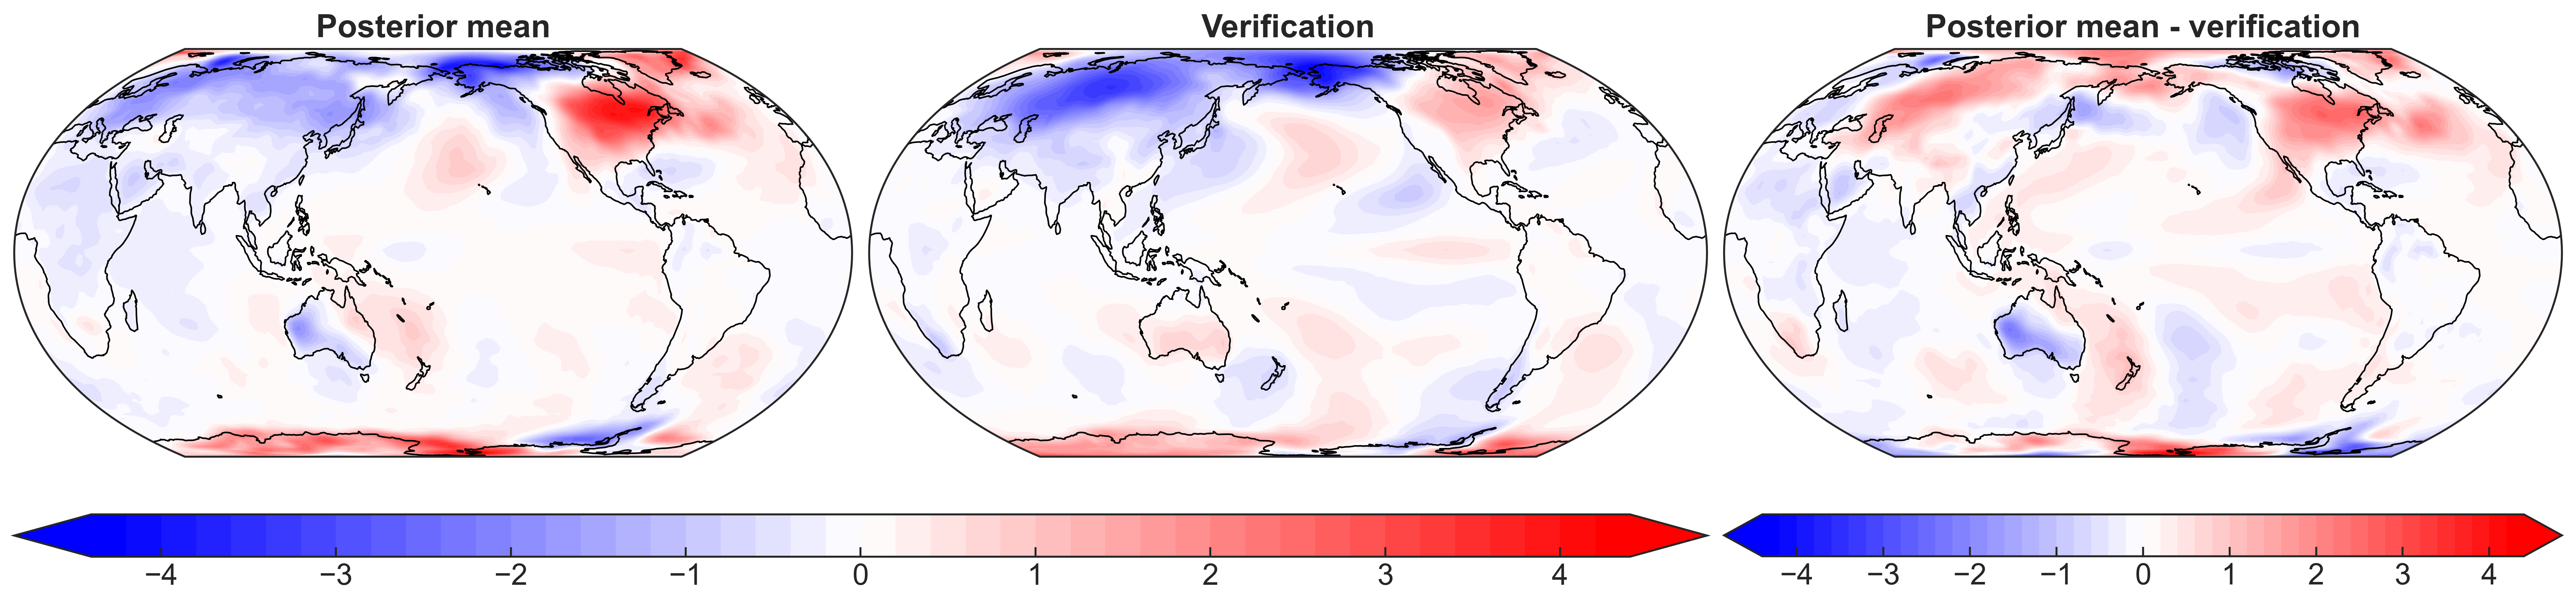

In [32]:
def plot_posterior_verification():
    fig, axs = plt.subplots(1, 3, figsize=(18, 8), subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=180)))

    plot_field(axs[:2], [
        unstack_state(posterior.mean("ens"))["tas"],
        data_ver.sel(time=prior.time)["tas"],
    ], n_level=50, cbar_aspect=40)
    plot_field(axs[2:], [
        unstack_state(posterior.mean("ens"))["tas"] - data_ver.sel(time=prior.time)["tas"],
    ], n_level=50)
    axs[0].set_title("Posterior mean")
    axs[1].set_title("Verification")
    axs[2].set_title("Posterior mean - verification")

    # axs[0].scatter(obs_to_assimilate.lon, obs_to_assimilate.lat, transform=ccrs.PlateCarree(), s=30, marker="x", color="red")

    for ax in axs.flatten():
        ax.coastlines()
        ax.set_global()

plot_posterior_verification()

# Localization

In [22]:
def plot_gc5thorder():
    xx = np.linspace(0, 3500, 100)

    fig, ax = plt.subplots()
    ax.plot(xx, localize_gc5thorder(xx, 3000))

plot_gc5thorder()

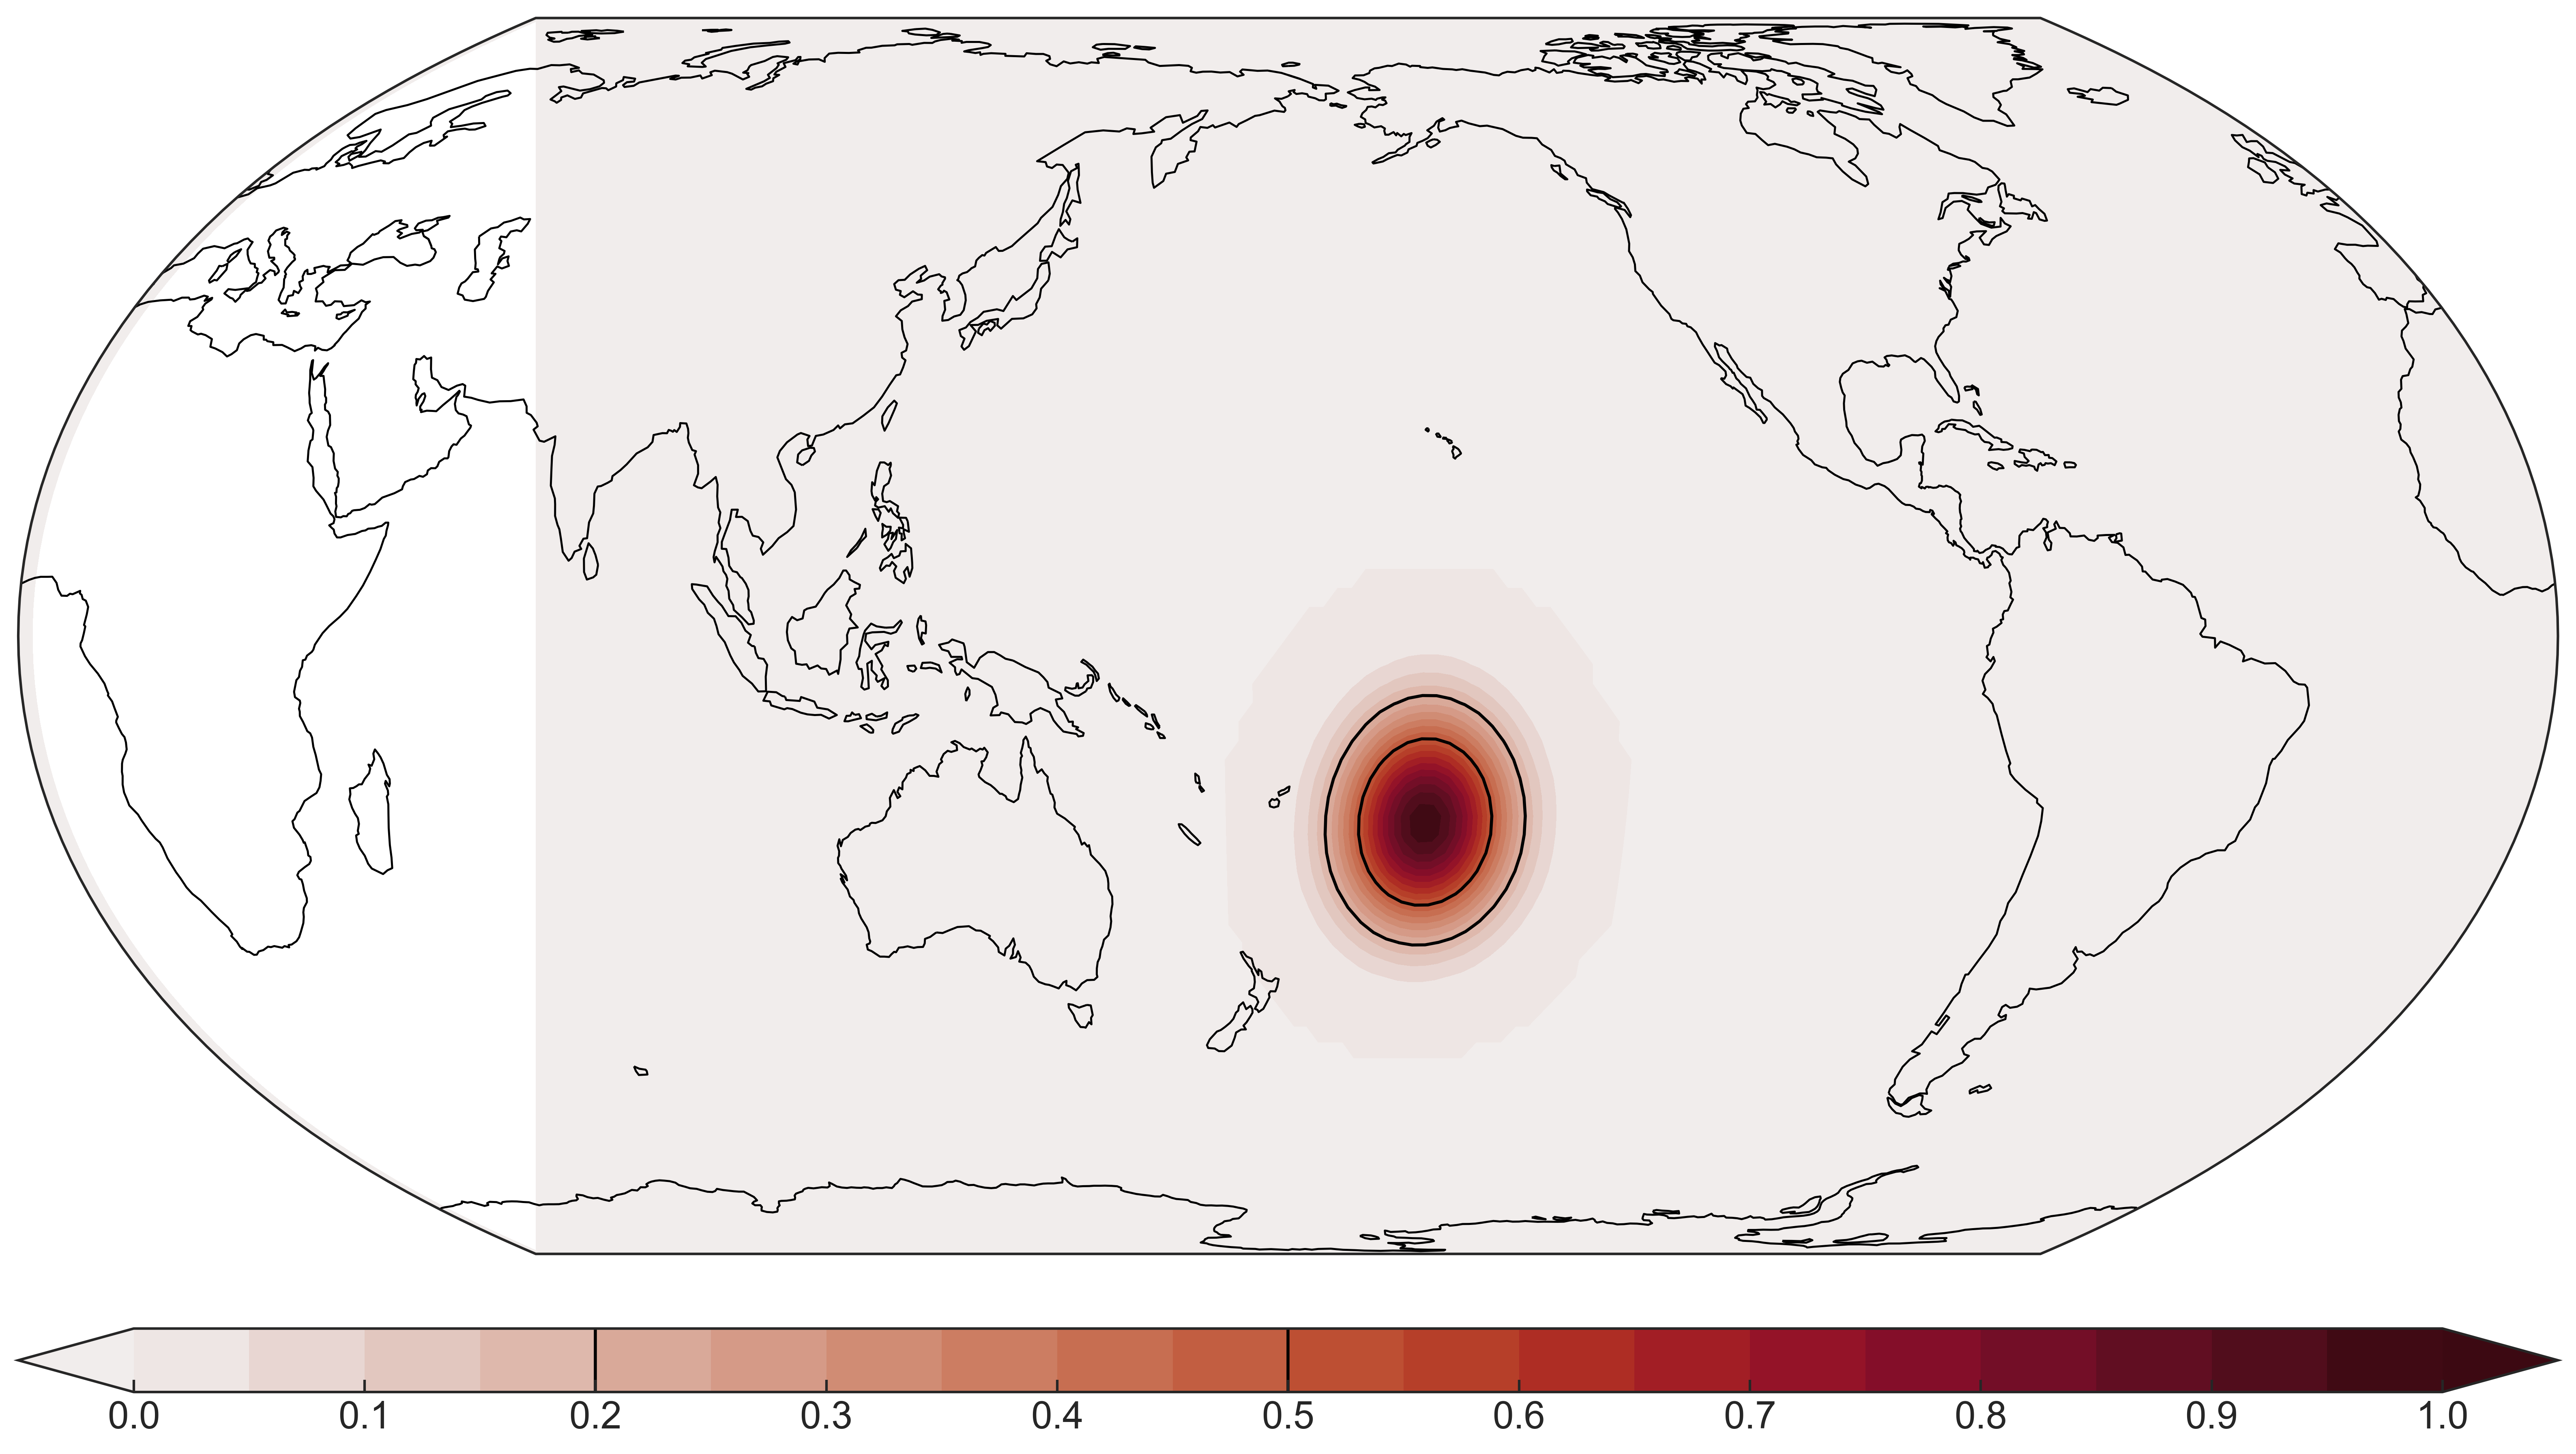

In [36]:
def plot_localization_map(lat_base, lon_base, loc_rad):
    fig, ax = plt.subplots(figsize=(14, 8), subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=180)))

    lats = np.linspace(-90, 90, 90)
    lons = np.linspace(0, 360, 180)
    lat_grid, lon_grid = np.meshgrid(lats, lons)

    da = xr.DataArray(
        localize_gc5thorder(get_spherical_distance(lat_base, lon_base, lat_grid, lon_grid), loc_rad),
        coords={
            "lon": ("lon", lons), "lat": ("lat", lats)
        }
    )

    # ax.pcolormesh(lon_grid, lat_grid, da.values, transform=ccrs.PlateCarree(), cmap="Blues")

    plot_field(ax, da,
               same_limits=False, cmap=cmocean.cm.amp, cbar_aspect=40,
               highlight_contours=[0.2, 0.5], n_level=21, cbar_ticks=np.arange(0, 1.1, 0.1))
    ax.coastlines()

plot_localization_map(-20, 200, 3000) 